In [1]:
#GPU확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os #파일경로 불러오기용
import cv2 #이미지 처리용
import pandas as pd #데이터 프레임 조작용

In [4]:
from PIL import Image
def create_df(data_path):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        try:
          image = Image.open(img_path)
          image.verify()
          img_path_list.append(img_path)
        except:
          print(img_path)
          pass
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [5]:
df = create_df('F:/PDC_2022/PDC_2022/track1/submission/augdata/train')

['cse', 'hh', 'rg', 'wb', 'wjj']
cse 6954
hh 4512
rg 6216
wb 6168
wjj 6318


In [6]:
display(df)

File_path Label
0      F:/PDC_2022/PDC_2022/track1/submission/augdata...    hh
1      F:/PDC_2022/PDC_2022/track1/submission/augdata...    wb
2      F:/PDC_2022/PDC_2022/track1/submission/augdata...    hh
3      F:/PDC_2022/PDC_2022/track1/submission/augdata...   wjj
4      F:/PDC_2022/PDC_2022/track1/submission/augdata...    rg
...                                                  ...   ...
30163  F:/PDC_2022/PDC_2022/track1/submission/augdata...    rg
30164  F:/PDC_2022/PDC_2022/track1/submission/augdata...    wb
30165  F:/PDC_2022/PDC_2022/track1/submission/augdata...    hh
30166  F:/PDC_2022/PDC_2022/track1/submission/augdata...    hh
30167  F:/PDC_2022/PDC_2022/track1/submission/augdata...   cse

[30168 rows x 2 columns]

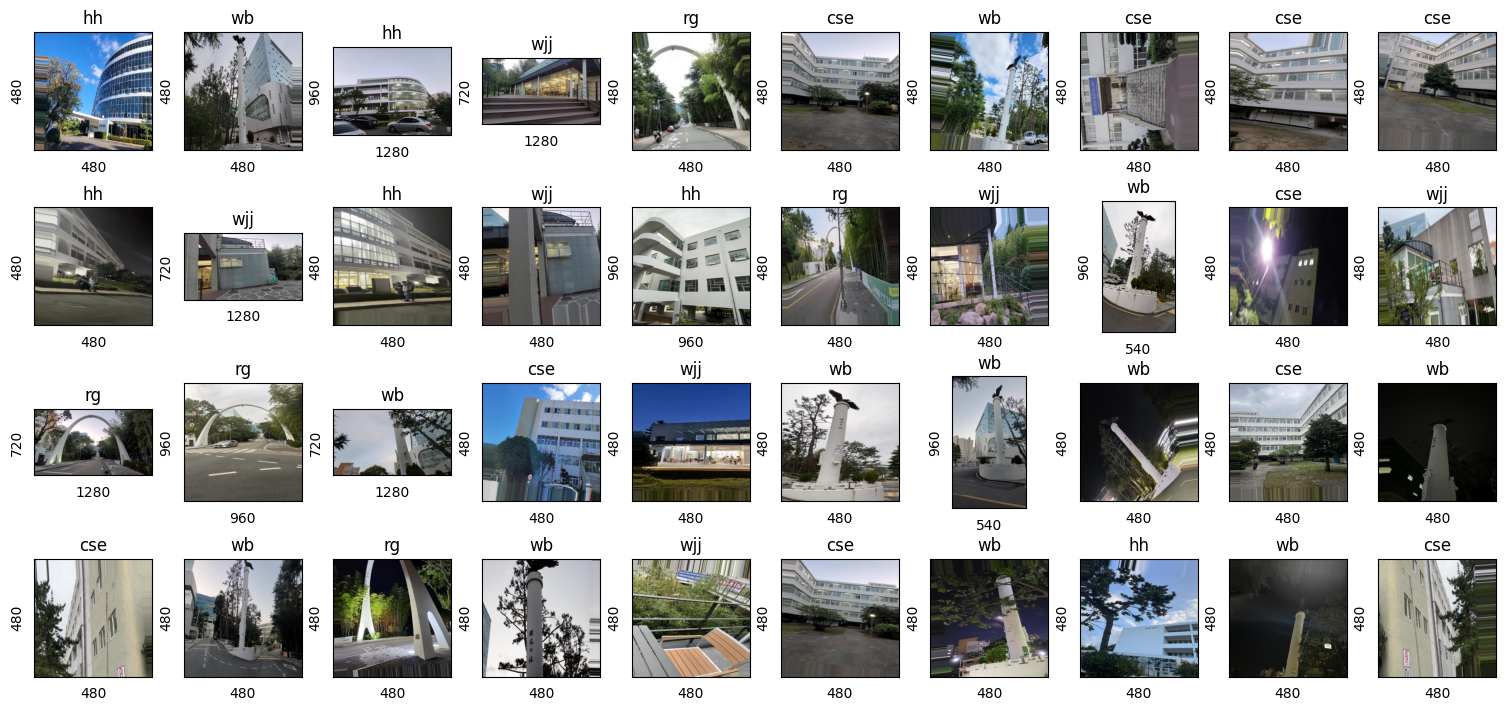

In [7]:
import matplotlib.pyplot as plt
"""
  데이터 확인(이미지 라벨, 가로크기,세로크기)
"""
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.File_path[i]))
    img = cv2.imread(df.File_path[i])
    ax.set_title(df.Label[i], fontsize = 12)
    ax.set_xlabel(img.shape[1], fontsize=10)
    ax.set_ylabel(img.shape[0], fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
"""
  훈련데이터,검증데이터로 나누기, 9:1, 계층샘플링적용
"""
train_df,val_df = train_test_split(df, test_size=0.1,random_state=0,stratify=df.Label)
print(train_df.shape,val_df.shape)

test_df = create_df('F:/PDC_2022/PDC_2022/track1/submission/dataset/test')


(27151, 2) (3017, 2)
['cse', 'hh', 'rg', 'wb', 'wjj']
cse 126
hh 88
rg 113
wb 113
wjj 124


In [9]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    
    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,val_generator,test_generator,train_images,val_images,test_images

In [10]:
import time
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = time.perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,validation_steps=5,epochs=1,verbose=1)
    
    # 학습시간과 val_accuracy 저장
    duration = time.perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 27151 validated image filenames belonging to 5 classes.
Found 3017 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


849/849 [==============================] - 160s 179ms/step - loss: 0.1642 - accuracy: 0.9415 - val_loss: 0.3519 - val_accuracy: 0.9000
DenseNet121          trained in 160.44 sec
849/849 [==============================] - 133s 154ms/step - loss: 0.1644 - accuracy: 0.9403 - val_loss: 0.3927 - val_accuracy: 0.9094
MobileNetV2          trained in 133.37 sec
849/849 [==============================] - 169s 189ms/step - loss: 0.1471 - accuracy: 0.9468 - val_loss: 0.2361 - val_accuracy: 0.9281
DenseNet201          trained in 169.2 sec
849/849 [==============================] - 145s 166ms/step - loss: 0.2589 - accuracy: 0.9067 - val_loss: 0.3671 - val_accuracy: 0.8969
InceptionV3          trained in 145.34 sec
849/849 [==============================] - 142s 164ms/step - loss: 0.9066 - accuracy: 0.6457 - val_loss:

In [11]:
# test데이터로 모델 성능 예측
from sklearn.metrics import accuracy_score
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['accuracy'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['accuracy'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

**DenseNet121 has a 97.87% accuracy on the test set**
**MobileNetV2 has a 95.92% accuracy on the test set**
**DenseNet201 has a 97.34% accuracy on the test set**
**InceptionV3 has a 94.68% accuracy on the test set**
**MobileNetV3Large has a 79.79% accuracy on the test set**
**ResNet152V2 has a 97.52% accuracy on the test set**
**ResNet50 has a 76.42% accuracy on the test set**
**ResNet50V2 has a 98.40% accuracy on the test set**
**VGG19 has a 95.04% accuracy on the test set**
**VGG16 has a 94.86% accuracy on the test set**
**Xception has a 96.63% accuracy on the test set**


model  val_accuracy  accuracy  Training time (sec)
0         ResNet50V2        0.9438    0.9840               136.36
1        DenseNet121        0.9000    0.9787               160.44
2        ResNet152V2        0.9281    0.9752               203.92
3        DenseNet201        0.9281    0.9734               169.20
4           Xception        0.8938    0.9663               143.12
5        MobileNetV2        0.9094    0.9592               133.37
6              VGG19        0.8781    0.9504               186.76
7              VGG16        0.8750    0.9486               158.88
8        InceptionV3        0.8969    0.9468               145.34
9   MobileNetV3Large        0.4781    0.7979               142.15
10          ResNet50        0.2969    0.7642               138.40

In [14]:
models['ResNet50V2']['model'].save('augmentation_TL_resnet50v2_1epoch_test_acc_0.98.h5')

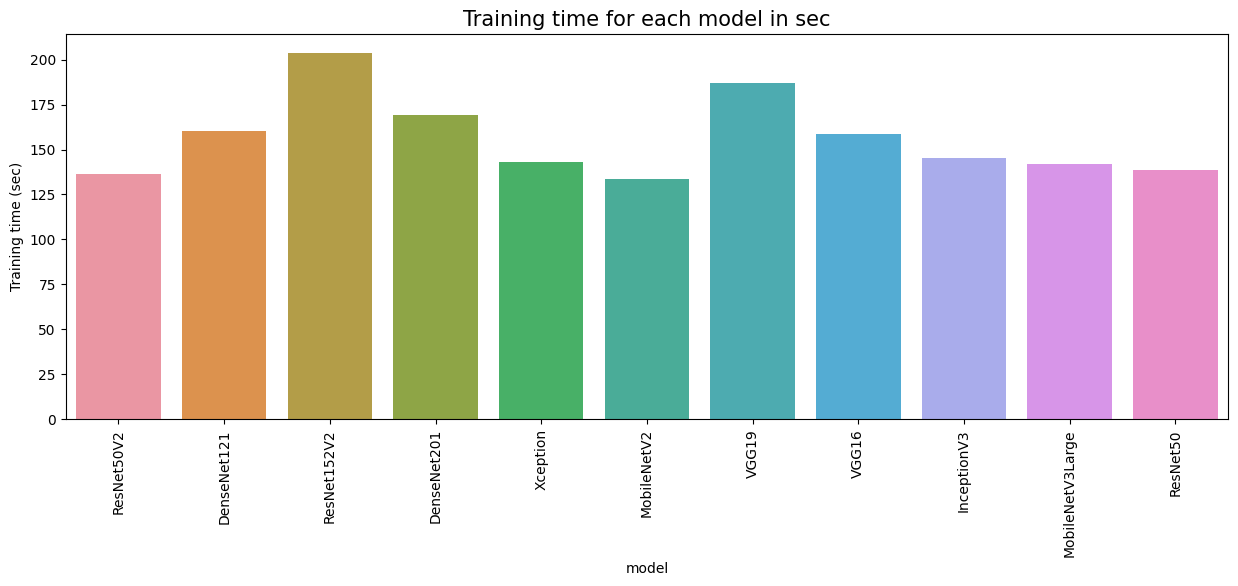

In [12]:
import seaborn as sns
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os #파일경로 불러오기용
import cv2 #이미지 처리용
import pandas as pd #데이터 프레임 조작용
import random
"""
이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
"""
from PIL import Image
def create_df(data_path):
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        img_path_list.append(img_path)
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [2]:
"""
데이터 로더
"""
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    
    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,val_generator,test_generator,train_images,val_images,test_images


In [3]:
"""
Train,Val,Test DF생성
"""
df = create_df('F:/PDC_2022/PDC_2022/track1/submission/augdata/train')

#훈련데이터,검증데이터로 나누기, 9:1, 계층샘플링적용
train_df,val_df = train_test_split(df, test_size=0.1,random_state=0,stratify=df.Label)
print(train_df.shape,val_df.shape)

test_df = create_df('F:/PDC_2022/PDC_2022/track1/submission/dataset/test')

['cse', 'hh', 'rg', 'wb', 'wjj']
cse 6954
hh 4512
rg 6216
wb 6168
wjj 6318
(27151, 2) (3017, 2)
['cse', 'hh', 'rg', 'wb', 'wjj']
cse 126
hh 88
rg 113
wb 113
wjj 124


In [4]:
train_generator,val_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 27151 validated image filenames belonging to 5 classes.
Found 3017 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


In [5]:
"""
랜덤 시드 고정
"""
def fix_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
"""
모델링
"""
def get_model(model):
    # Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False# 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    tuning_layer_name = 'conv5_block1_preact_bn'
    tuning_layer = pretrained_model.get_layer(tuning_layer_name)
    tuning_index = pretrained_model.layers.index(tuning_layer)

    for layer in pretrained_model.layers[tuning_index:]:
        layer.trainable = True
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Flatten()(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이기 때문에 Dencs도 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='F:/PDC_2022/PDC_2022/track1/submission/checkpoint/epoch-{epoch}-val_loss-{val_loss:.4f}-val_acc-{val_accuracy:.4f}.h5', monitor='val_loss', save_best_only=True, verbose=1)
fix_seed(0)
model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=10,verbose=1,callbacks=[model_checkpoint])

Epoch 1/10
849/849 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9529
Epoch 1: val_loss improved from inf to 0.18119, saving model to F:/PDC_2022/PDC_2022/track1/submission/checkpoint\epoch-1-val_loss-0.1812-val_acc-0.9539.h5
849/849 [==============================] - 177s 200ms/step - loss: 0.1535 - accuracy: 0.9529 - val_loss: 0.1812 - val_accuracy: 0.9539
Epoch 2/10
849/849 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9850
Epoch 2: val_loss improved from 0.18119 to 0.06107, saving model to F:/PDC_2022/PDC_2022/track1/submission/checkpoint\epoch-2-val_loss-0.0611-val_acc-0.9818.h5
849/849 [==============================] - 159s 187ms/step - loss: 0.0506 - accuracy: 0.9850 - val_loss: 0.0611 - val_accuracy: 0.9818
Epoch 3/10
849/849 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9917
Epoch 3: val_loss did not improve from 0.06107
849/849 [==============================] - 158s 186ms/step - loss: 0.0297 - acc

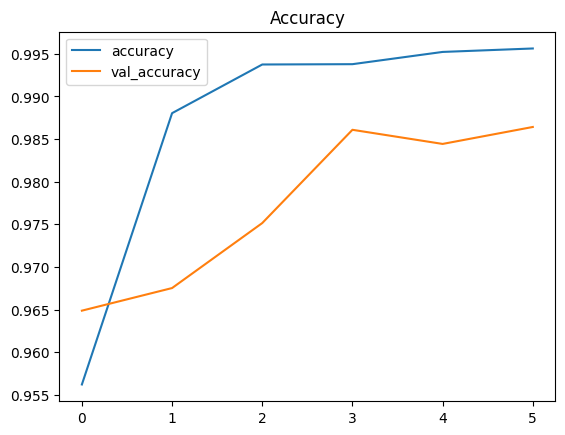

In [6]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

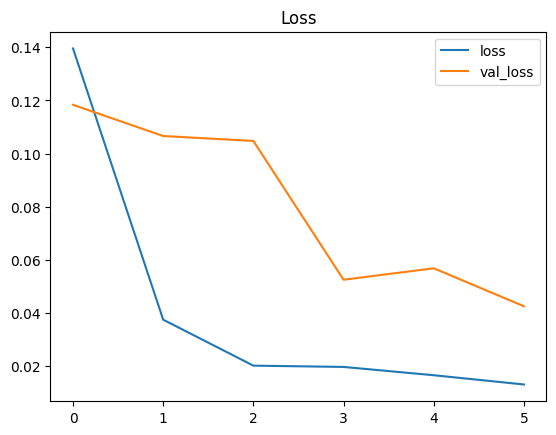

In [7]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [6]:
from sklearn.metrics import accuracy_score
from keras.models import load_model
model = load_model('F:/PDC_2022/PDC_2022/track1/submission/augmentaion_TL_ResNet50V2.h5')
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Accuracy on the test set: 99.47%


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1, digits=4)
print(class_report)

              precision    recall  f1-score   support

         cse     0.9921    1.0000    0.9960       126
          hh     1.0000    0.9659    0.9827        88
          rg     1.0000    1.0000    1.0000       113
          wb     0.9912    1.0000    0.9956       113
         wjj     0.9920    1.0000    0.9960       124

    accuracy                         0.9947       564
   macro avg     0.9951    0.9932    0.9941       564
weighted avg     0.9947    0.9947    0.9946       564



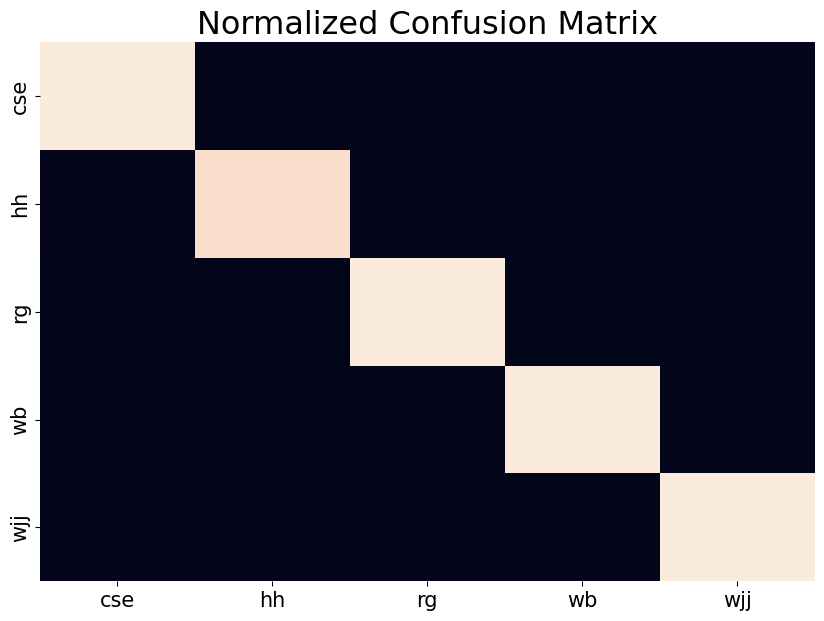

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [13]:
model.save('augmentaion_TL_ResNet50V2.h5')

'예측률 : 100.00%'

'Class prediction = wb'

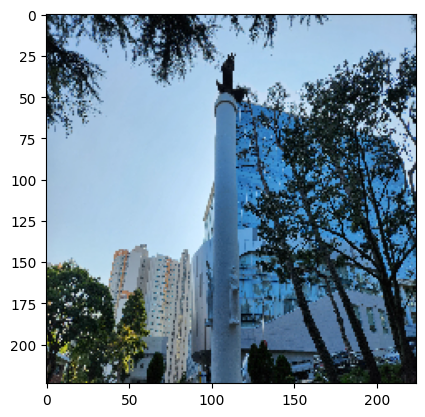

In [10]:
#모델 로드 후 개별 이미지 예측 테스트
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.applications.resnet_v2 import preprocess_input
def printmd(string):
    display(string)
class_dictionary = test_images.class_indices
model = load_model('F:/PDC_2022/PDC_2022/track1/submission/augmentaion_TL_ResNet50V2.h5')
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"Class prediction = {x}")
    break

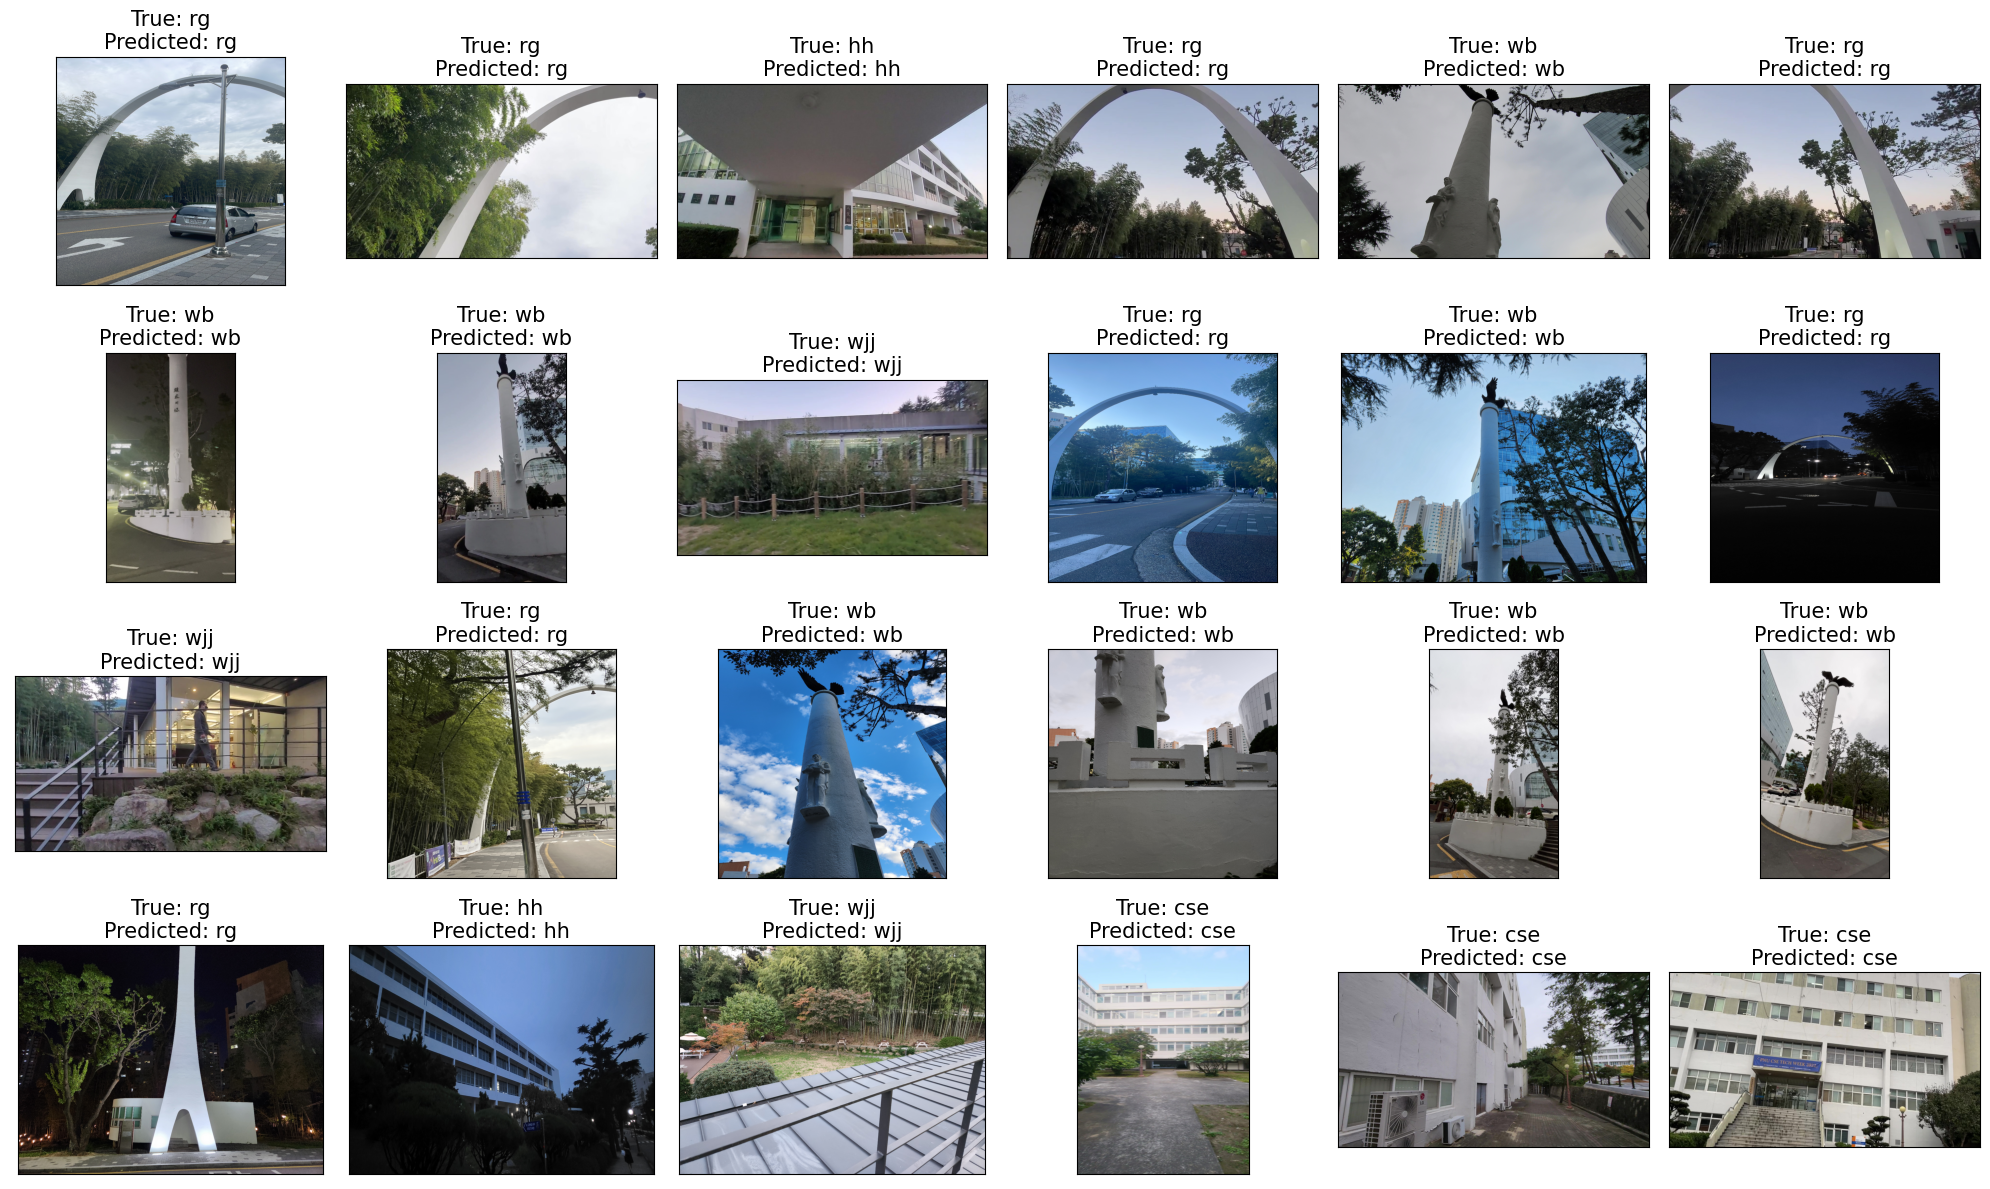

In [11]:
#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    test_image = preprocess_input(test_image)
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()

In [12]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
model = tf.keras.models.load_model('F:/PDC_2022/PDC_2022/track1/submission/augmentaion_TL_ResNet50V2.h5')
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)
test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=1,
        shuffle=False)

result = dict()
for cls in test_images.class_indices.keys():
        result[test_images.class_indices[cls]] = [0, 0]
pbar = tqdm(total=test_images.samples, dynamic_ncols=True)
for batch, sample in enumerate(test_images):
        img, label = sample[0], int(np.argmax(sample[1],1))
        output = model.predict(img)
        pred = int(np.argmax(output,1))
        gt = label

        result[gt][1] += 1
        if pred == gt:
                result[gt][0] += 1
        if batch == int(test_images.samples):
                break
        pbar.update(1)

pbar.close()
correct_all = 0
total_all = 0
classes = dict(map(reversed,test_images.class_indices.items()))
for k, v in result.items():
        cls = classes[k]
        correct = result[k][0]
        total = result[k][1]
        acc = 100. * correct / (total + 1e-8)
        print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format(
                cls, correct, total, acc
        ))

        correct_all += correct
        total_all += total

acc_all = 100. * correct_all / (total_all + 1e-8)
print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format("ALL", correct_all, total_all, acc_all))

Found 564 validated image filenames belonging to 5 classes.


100%|██████████| 564/564 [00:38<00:00, 14.76it/s]

  cse    |   126    |   126    |   100.0000
   hh    |    85    |    88    |    96.5909
   rg    |   114    |   114    |   100.0000
   wb    |   113    |   113    |   100.0000
  wjj    |   124    |   124    |   100.0000
  ALL    |   562    |   565    |    99.4690
